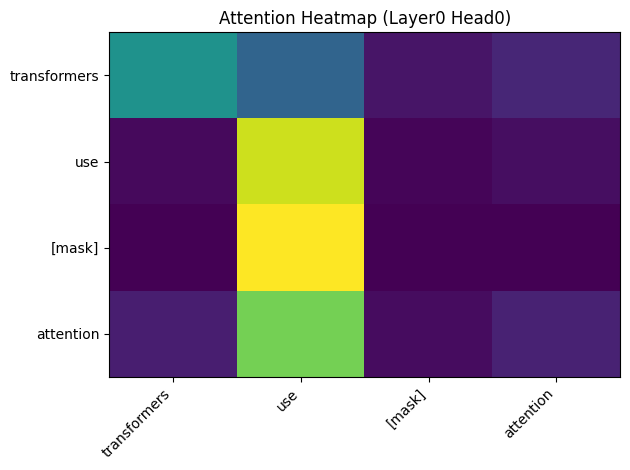

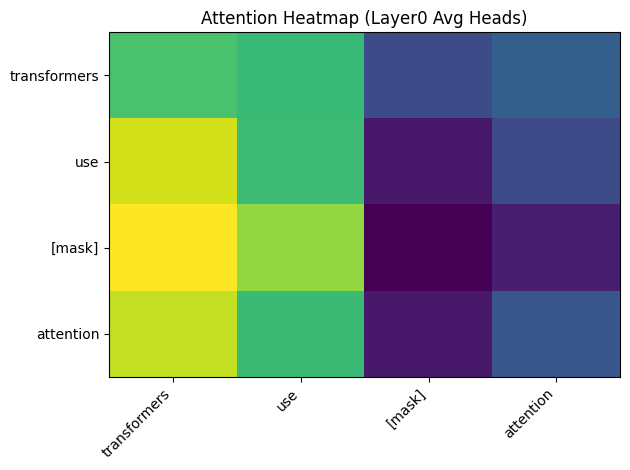

Saved heatmaps to results/


In [1]:
import os
import torch
import matplotlib.pyplot as plt

from encoder import MLMModel

CKPT = "results/mlm_model.pt"

def tokenize(s): return s.lower().split()

def encode(sentence, stoi, max_len=12):
    PAD = "[PAD]"
    UNK = "[UNK]"
    toks = tokenize(sentence)
    ids = [stoi.get(t, stoi[UNK]) for t in toks][:max_len]
    attn = [1]*len(ids)
    while len(ids) < max_len:
        ids.append(stoi[PAD]); attn.append(0)
    return torch.tensor(ids).unsqueeze(0), torch.tensor(attn).unsqueeze(0), toks

def plot_heatmap(mat, tokens, title, save_path=None):
    plt.figure()
    plt.imshow(mat, aspect="auto")
    plt.xticks(range(len(tokens)), tokens, rotation=45, ha="right")
    plt.yticks(range(len(tokens)), tokens)
    plt.title(title)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200)
    plt.show()

def main():
    os.makedirs("results", exist_ok=True)

    ckpt = torch.load(CKPT, map_location="cpu")
    stoi = ckpt["stoi"]
    itos = ckpt["itos"]

    model = MLMModel(vocab_size=len(stoi), d_model=64, num_heads=4, d_ff=128, num_layers=2, max_len=12)
    model.load_state_dict(ckpt["model"])
    model.eval()

    
    sentence = "transformers use [mask] attention"
    x, a, toks = encode(sentence, stoi, max_len=12)

    with torch.no_grad():
        _ = model(x, attn_mask=a)

    attn = model.encoder.layers[0].attn.last_attn[0]   # [heads, T, T]

    T_real = int(a[0].sum().item())
    tokens = toks[:T_real]

    head0 = attn[0, :T_real, :T_real].cpu().numpy()
    avg = attn[:, :T_real, :T_real].mean(dim=0).cpu().numpy()

    plot_heatmap(head0, tokens, "Attention Heatmap (Layer0 Head0)", "results/attn_example_head0.png")
    plot_heatmap(avg, tokens, "Attention Heatmap (Layer0 Avg Heads)", "results/attn_example_avg.png")

    print("Saved heatmaps to results/")

if __name__ == "__main__":
    main()

